In [1]:
import pandas as pd
import numpy as np
import torch
DATA = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00448/carbon_nanotubes.csv',sep = ';', decimal=",")
print(DATA)
#This is the carbon nanotubes data.
DATA = DATA.drop("Calculated atomic coordinates u'", axis=1) #This dataset has three targets for multivariate regression. 
DATA = DATA.drop("Calculated atomic coordinates v'", axis=1) #This dataset has three targets for multivariate regression. 
#But we would like to, for simplicity's sake, stick to univariate regression.
DATA = DATA.astype(float)
#print(DATA)
#print(DATA)
DATA = DATA.to_numpy()
DATA = torch.from_numpy(DATA)
#print(DATA)
np.random.seed(42069)

DATA = DATA.type(torch.float32)

data_mean = DATA.mean(axis=1)[0:6]
data_std = DATA.std(axis=1)[0:6]
DEVICE = torch.device("cuda:1")

#DATA[:,7] = 5*DATA[:,1] + 3*DATA[:,6] + 2*DATA[:,3] + 1*DATA[:,2] 
DATA[:,0:6] = (DATA[:,0:6]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(10721, 6000, replace = False)

dTRAIN_CARBON = DATA[tr_ids,:]
dTEST_CARBON = DATA[-tr_ids,:]

print(DATA)

       Chiral indice n  Chiral indice m  Initial atomic coordinate u  \
0                    2                1                     0.679005   
1                    2                1                     0.717298   
2                    2                1                     0.489336   
3                    2                1                     0.413957   
4                    2                1                     0.334292   
...                ...              ...                          ...   
10716               12                6                     0.834201   
10717               12                6                     0.698374   
10718               12                6                     0.923823   
10719               12                6                     0.934978   
10720               12                6                     0.953664   

       Initial atomic coordinate v  Initial atomic coordinate w  \
0                         0.701318                     0.017033   
1

In [2]:
import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib
import matplotlib.pyplot as plt

COND_OPT = False
CLASSES = 1
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 30

TEST_BATCH_SIZE = 6000
BATCH_SIZE = 100

import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

data_shape = (0,5,5,6)
l1shape=(5, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 1)
layershapes = [l1shape, l2shape, l3shape, l4shape]

trtimes  = []

epochs =10

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net5= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                #w_kappa=torch.Tensor(1).uniform_(5,5.1),
                                Temper = 0.1,
                                classification='Regression')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net5.parameters(), lr=0.0007)
    
    
    for epoch in range(epochs):
        train = FVMF.train(net5, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(net5,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('Gaussian 10 epoch')
    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(0.8478, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.2239, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(0.7924, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1670, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(0.7103, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0952, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(0.7032, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0924, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(0.6755, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0894, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(0.6902, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0871, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(0.7012, device='cuda:1', gra

In [3]:
epochs = 20


for epoch in range(epochs):
    train = FVMF.train(net5, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                shape = data_shape,CLASSES = 1)    
    trtimes.append(train[1].detach().cpu().numpy())
    #print('max:',net4.weight_mu[1].max())
    #print('norm:',torch.norm(net4.weight_mu[1]))

loss, outputs, output = test_ensemble.test_ensemble(net5,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                  CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
print('Gaussian 30 epoch')

1
loss: tensor(0.0457, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0457, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(0.0054, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0054, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(0.0027, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0027, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(0.0167, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0167, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(0.0015, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0015, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(0.0077, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0077, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(0.0031, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0031, device='cuda:1', gra

In [4]:
epochs = 20

for epoch in range(epochs):
    train = FVMF.train(net5, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                shape = data_shape,CLASSES = 1)    
    trtimes.append(train[1].detach().cpu().numpy())
    #print('max:',net4.weight_mu[1].max())
    #print('norm:',torch.norm(net4.weight_mu[1]))

loss, outputs, output = test_ensemble.test_ensemble(net5,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                  CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
print('Gaussian 50 epoch')

1
loss: tensor(0.0020, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0020, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(0.0078, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0078, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(0.0021, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0021, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(0.0013, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0013, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(0.0025, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0025, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(0.0028, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0028, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(0.0086, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0086, device='cuda:1', gra

Gaussian loss curve, 50 epoch regression


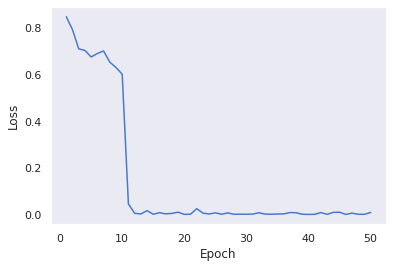

In [5]:
x = []
for i in range(50):
    x.append(i+1)
print('Gaussian loss curve, 50 epoch regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_50_epoch_regression.png')
plt.show()

In [17]:
trtimes  = []
epochs = 30

#Note, for this regression task, the last 7 to 1 layer has a Gaussian VD, where we kill the prior and simply optimize with MLE.
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression30= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(7.5,7.6),
                                Temper = 0,classification='Regression',NODEFORCE =False)
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression30.parameters(), lr=0.08)
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression30, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        print('max:',vMFRegression30.weight_mu[1].max())
        print('norm:',torch.norm(vMFRegression30.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression30,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 30 epoch')

0
Random Init Utilized
1
loss: tensor(0.0963, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0963, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2822, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.7391, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.0868, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0868, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2961, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(9.2026, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.0382, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0382, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2975, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(7.8344, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.0113, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0113, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.3658, d

In [18]:

epochs = 20


for epoch in range(epochs):
    train = FVMF.train(vMFRegression30, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                shape = data_shape,CLASSES = 1)    
    trtimes.append(train[1].detach().cpu().numpy())
    print('max:',vMFRegression30.weight_mu[1].max())
    print('norm:',torch.norm(vMFRegression30.weight_mu[1]))
loss, outputs, output = test_ensemble.test_ensemble(vMFRegression30,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                  CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
print('vMF 50 epoch')

1
loss: tensor(0.0120, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0120, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(7.3972, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(13.5032, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.0140, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0140, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(7.5367, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(13.6858, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.0241, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0241, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(7.3280, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(13.6593, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.0083, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0083, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(7.6334, device='cuda:1', grad

vMF loss curve, 50 epoch regression


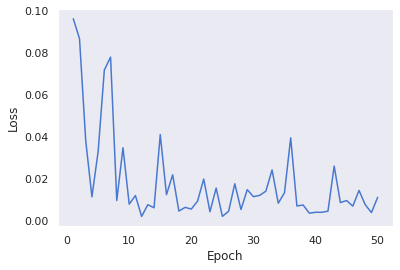

In [19]:
x = []
for i in range(50):
    x.append(i+1)
print('vMF loss curve, 50 epoch regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_50_epoch_regression.png')
plt.show()

In [2]:
import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib
import matplotlib.pyplot as plt

COND_OPT = False
CLASSES = 1
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 30

TEST_BATCH_SIZE = 6000
BATCH_SIZE = 100

import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

data_shape = (0,5,5,6)
l1shape=(5, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 1)
layershapes = [l1shape, l2shape, l3shape, l4shape]

epochs = 30
trtimes = []


for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(7.5,7.6),
                                Temper = 0,classification='Regression',NODEFORCE =False)
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression.parameters(), lr=0.11)
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        print('max:',vMFRegression.weight_mu[1].max())
        print('norm:',torch.norm(vMFRegression.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 25 epoch')
    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu_R = []
for i in range(len(vMFRegression.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu_R.append(vMFRegression.weight_mu[i]/torch.norm(vMFRegression.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu_R = []
for i in range(len(vMFRegression.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu_R.append(vMFRegression.bias_mu[i]/torch.norm(vMFRegression.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho_R= []
for i in range(len(vMFRegression.bias_rho)):
    b_rho_R.append(vMFRegression.bias_rho[i])

w_rho_R= []
for i in range(len(vMFRegression.weight_rho)):
    w_rho_R.append(vMFRegression.weight_rho[i])
#For some reason, it seems that the weights are not being properly normalized here. no actually they are, but the norm reported is the norm after 1 optimization step.

epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression2= FVMF.BayesianNetwork(w_mu = w_mu_R, b_mu = b_mu_R, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa= b_rho_R, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho_R, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'regression')
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression2.parameters(), lr=0.01) #0.01 9727 acc
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression2, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression2.weight_mu[1].max())
        #print('norm:',torch.norm(vMFRegression2.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression2,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 30+20 epoch NII')

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(0.0891, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0891, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.5014, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.3171, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.0845, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0845, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.4328, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.0394, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.0580, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0580, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.8436, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(7.9262, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.0884, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0884, devic


 This is the TSS 1156.893798828125 This is the SS_res: 106.65696716308594 
 This is the R^2 on testset: tensor(0.9078, device='cuda:1')
vMF 25 epoch
0
1
loss: tensor(2.5112, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0295, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(2.5137, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0115, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(2.5708, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0372, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(2.6710, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0195, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(2.5709, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0175, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(2.5820, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0183, device='cuda:1

In [6]:
w_mu_R = []
for i in range(len(vMFRegression2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu_R.append(vMFRegression2.weight_mu[i]/torch.norm(vMFRegression2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu_R = []
for i in range(len(vMFRegression2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu_R.append(vMFRegression2.bias_mu[i]/torch.norm(vMFRegression2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho_R= []
for i in range(len(vMFRegression2.bias_rho)):
    b_rho_R.append(vMFRegression2.bias_rho[i])

w_rho_R= []
for i in range(len(vMFRegression2.weight_rho)):
    w_rho_R.append(vMFRegression2.weight_rho[i])
#For some reason, it seems that the weights are not being properly normalized here. no actually they are, but the norm reported is the norm after 1 optimization step.

epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression3= FVMF.BayesianNetwork(w_mu = w_mu_R, b_mu = b_mu_R, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa= b_rho_R, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho_R, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'regression')
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression2.parameters(), lr=0.08) #0.01 9727 acc
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression3, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression2.weight_mu[1].max())
        #print('norm:',torch.norm(vMFRegression2.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression3,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 10+20+20 epoch NII')

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(0.0963, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0963, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2822, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.7391, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.0868, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0868, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2961, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(9.2026, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.0382, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0382, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2975, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(7.8344, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.0113, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0113, device='cuda:1', grad_fn=<MeanBack

KeyboardInterrupt: 

In [ ]:
x = []
for i in range(50):
    x.append(i+1)
print('NIIvMF loss curve, 50 epoch regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/NIIvMF_loss_50_epoch_regression.png')
plt.show()